<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Geophysikalisches Praktikum: `Digital elevation model

## DEM model from LIDAR data
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.interpolate
import libGP

In this notebook, we will read and plot a **digital elevation model** (DEM) derived from
Lidar data from [Berlin](https://fbinter.stadt-berlin.de/fb/index.jsp?loginkey=zoomStart&mapId=k_dgm1@senstadt&bbox=378400,5816319,382550,5819191).
<img src="images/Campus_3Dtopo.png" style="height:5cm">

----
## Reading elevation file
As we have already reformatted the Lidar data to our `geodyn5` format,
we just need to write a function reading this format by
- **reading meta data:**
The first lines (starting with an exclamation mark) are **meta-data** of the dataset,
describing its content, technial details such as the source, the coordinate system,
and the content of the different columns
- **reading elevation data:**
The rest of the file are real data

In [2]:
elevFile = "data/FUGeocampus/2Dm_GP2024_DTM.xy"
f = open(elevFile,'r')
topolines = f.readlines()
f.close()
print(len(topolines))

160810


This simple ascii file contains triple of
- easting [m]
- northing [m]
- elevation [m]
without any meta data.

**Note:** This file contains more than 4 mill entries, therefore we have extracted the relevant elevation data
for the FU Geocampus, and stored them in the same format as `data/FUGeocampus/FUGeocampus_topo.xyz`.

We read this data file with `np.loadtxt` and create data array `data`:

In [3]:
imeta=0; itopodata=0; i=0;iskip =1
# create data fields (datetime, easting, northing, elevation)
datetime  =[]
easting   = np.empty(0)
northing  = np.empty(0)
elevation = np.empty(0)
# loop over lines, separate meta-data from data, fill fields, skip every iskip lines
for line in topolines:
    # Get next line from file
    if (line[0] == '!'):
        imeta += 1
        #print(line.split())
    else:
        i += 1
        if (i%iskip == 0):
            itopodata += 1
            easting = np.append(easting,[float(line.split()[1])],axis=0)
            northing = np.append(northing,[float(line.split()[2])],axis=0)
            elevation = np.append(elevation,[float(line.split()[3])],axis=0)
            datetime.append(line.split()[0])

print('File read:                 ',elevFile)
print('Number of topo lines:      ',len(topolines))
print('Number of meta-data read:  ',imeta)
print('Number of topo data read:  ',itopodata)
print('min/max easting:           ',easting.min(),easting.max())
print('min/max northing:          ',northing.min(),northing.max())
print('min/max elevation:         ',elevation.min(),elevation.max())

File read:                  data/FUGeocampus/2Dm_GP2024_DTM.xy
Number of topo lines:       160810
Number of meta-data read:   9
Number of topo data read:   160801
min/max easting:            388200.0 388600.0
min/max northing:           5809500.0 5809900.0
min/max elevation:          40.43 46.28


## Plot DEM data
Next, we plot the data as 2D plot:

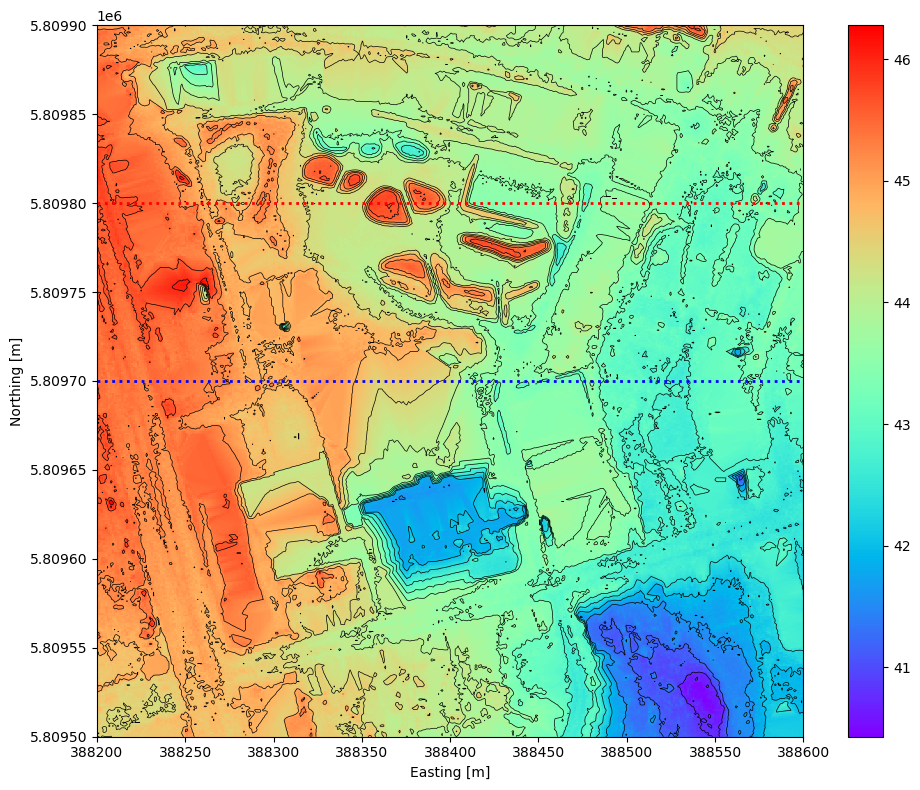

In [4]:
#-----------------------------------------------------------------------
# create regular 2D grid and plot data
#-----------------------------------------------------------------------
ndata = 400
x = np.linspace(easting.min(),easting.max(),ndata)
y = np.linspace(northing.min(),northing.max(),ndata)
xi,yi = np.meshgrid(x,y)
#zi = scipy.interpolate.griddata ((topo[:,0],topo[:,1]),topo[:,2],(xi,yi), method='linear')
zi = scipy.interpolate.griddata ((easting[:],northing[:]),elevation[:],(xi,yi), method='nearest')
#-----------------------------------------------------------------------
# plot topography
#-----------------------------------------------------------------------
fig,ax1 = plt.subplots(1,1,figsize=(10.0, 8.0))
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_xlim([388200,388600])
ax1.set_ylim([5809500,5809900])
ax1.ticklabel_format(useOffset=False)
ax1.contour(xi, yi, zi, 15, linewidths = 0.5, colors = 'k')
im=ax1.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('rainbow'),shading='auto')
fig.colorbar(im,ax=ax1)
ax1.plot([388200,388600],[5809700,5809700],linestyle=':',linewidth=2,color='blue')
ax1.plot([388200,388600],[5809800,5809800],linestyle=':',linewidth=2,color='red')
plt.tight_layout()
plt.savefig("images/FUGeocampus_topo.png",bbox_inches='tight')

## Extract profiles from DEM data
We extract two west-east profiles from the DEM data ...

In [5]:
#-----------------------------------------------------------------------
# extract two profiles
#-----------------------------------------------------------------------
profile1 = np.empty(shape=[0,2])
profile2 = np.empty(shape=[0,2])
print (profile1.shape,profile2.shape)
for i in range(easting.shape[0]):
    if northing[i] > 5809799 and northing[i] < 5809801:
        profile2 = np.append(profile2,[[easting[i],elevation[i]]], axis=0)
    if northing[i] > 5809699 and northing[i] < 5809701:
        profile1 = np.append(profile1,[[easting[i],elevation[i]]], axis=0)
print ('%s data type: %s\n%s data dimensions: %s' % \
      ('profile1: ',type(profile1),'profile1: ',profile1.shape))
print ('%s data type: %s\n%s data dimensions: %s' % \
      ('profile2: ',type(profile2),'profile1: ',profile1.shape))
#-----------------------------------------------------------------------
# write profile data  into file
#-----------------------------------------------------------------------
outfile1='Campus1.xy'
print ('=============================')
print ('%s %s' % ('Writing file: ',outfile1))
np.savetxt(outfile1, profile1, fmt='%8.0f %8.2f', delimiter=' ')
outfile2='Campus2.xy'
print ('=============================')
print ('%s %s' % ('Writing file: ',outfile2))
np.savetxt(outfile2, profile2, fmt='%8.0f %8.2f', delimiter=' ')

(0, 2) (0, 2)
profile1:  data type: <class 'numpy.ndarray'>
profile1:  data dimensions: (401, 2)
profile2:  data type: <class 'numpy.ndarray'>
profile1:  data dimensions: (401, 2)
Writing file:  Campus1.xy
Writing file:  Campus2.xy


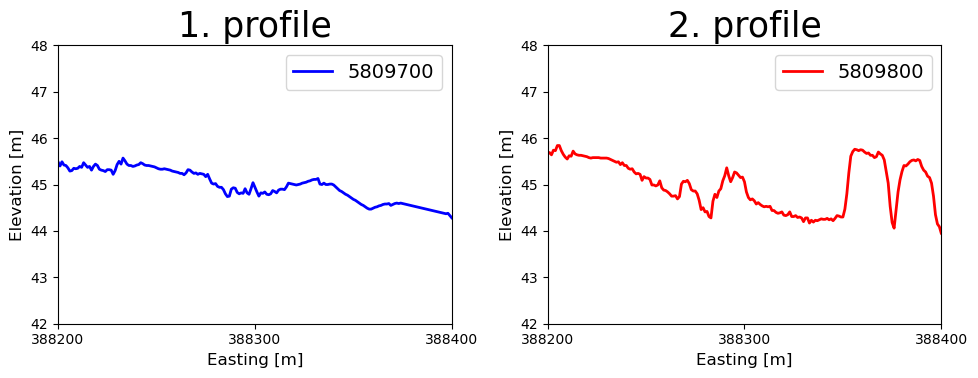

In [6]:
#-----------------------------------------------------------------------
# plot two profiles
#-----------------------------------------------------------------------
fig,axs = plt.subplots(1,2,figsize=(10.0, 4.0))
plt.rc("font",size=14)
axs[0].set_xlabel('Easting [m]',size=12)
axs[0].set_ylabel('Elevation [m]',size=12)
axs[0].set_title('1. profile',size=25)
axs[0].plot(profile1[:,0],profile1[:,1],color='blue',linestyle='-',linewidth=2,label='5809700')
#axs[0].plot(profile1[:,0],profile1[:,1],marker='x',markersize=4.5,color='blue')
axs[0].set_xlim([388200,388400])
axs[0].set_ylim([42,48])
axs[0].ticklabel_format(useOffset=False)
axs[0].set_xticks([388200,388300,388400])
axs[0].legend()

axs[1].set_xlabel('Easting [m]',size=12)
axs[1].set_ylabel('Elevation [m]',size=12)
axs[1].set_title('2. profile',size=25)
axs[1].plot(profile2[:,0],profile2[:,1],color='red',linestyle='-',linewidth=2,label='5809800')
#axs[1].plot(profile2[:,0],profile2[:,1],marker='x',markersize=4.5,color='red')
axs[1].set_xlim([388200,388400])
axs[1].set_ylim([42,48])
axs[1].ticklabel_format(useOffset=False)
axs[1].set_xticks([388200,388300,388400])
axs[1].legend()
plt.tight_layout()
plt.savefig("images/FUGeocampus_profiles.png")

## Plot structures on DEM 

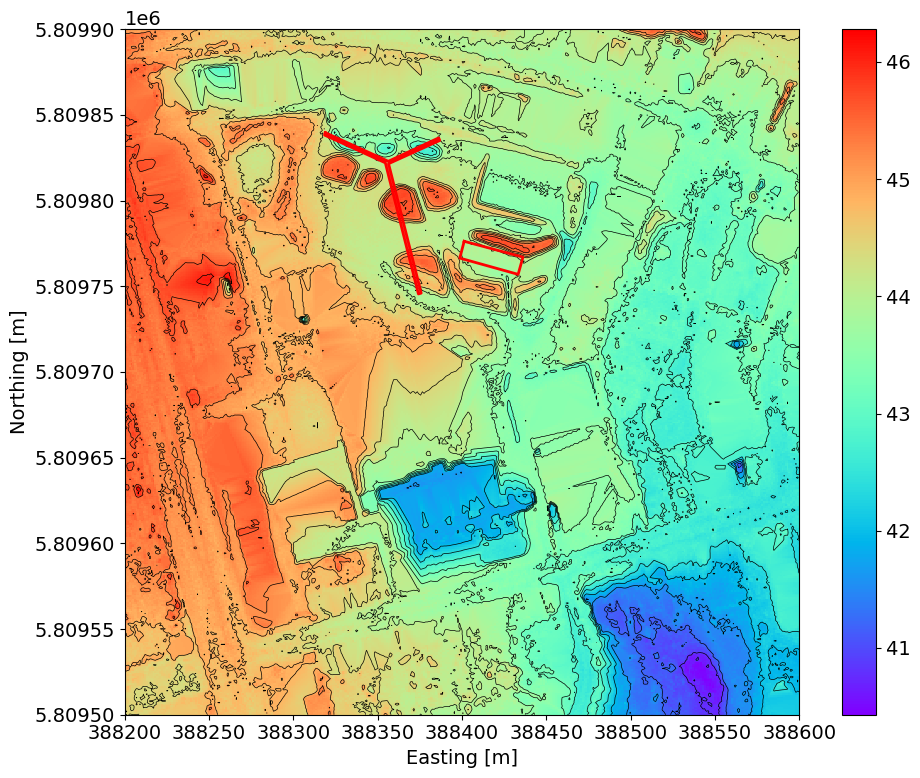

In [7]:
#-----------------------------------------------------------------------
# read data into field
#-----------------------------------------------------------------------
inpath='data/FUGeocampus/'
infile='Rigole.xy'
rigole=np.loadtxt(fname=inpath+infile,skiprows=1)
infile='Tunnel.xy'
tunnel=np.loadtxt(fname=inpath+infile,skiprows=1)
#-----------------------------------------------------------------------
# plot topography
#-----------------------------------------------------------------------
fig,ax1 = plt.subplots(1,1,figsize=(10.0, 8.0))

ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.ticklabel_format(useOffset=False)
ax1.contour(xi, yi, zi, 15, linewidths = 0.5, colors = 'k')
im=ax1.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('rainbow'),shading='auto')
fig.colorbar(im,ax=ax1)
ax1.plot(rigole[:,0],rigole[:,1],linestyle='-',linewidth=2,color='red')
ax1.plot(tunnel[:,0],tunnel[:,1],linestyle='-',linewidth=2,color='red')
ax1.set_xlim([388200,388600])
ax1.set_ylim([5809500,5809900])
plt.tight_layout()
plt.savefig("images/FUGeocampus_topo.png")

## 3D plot of DEM 

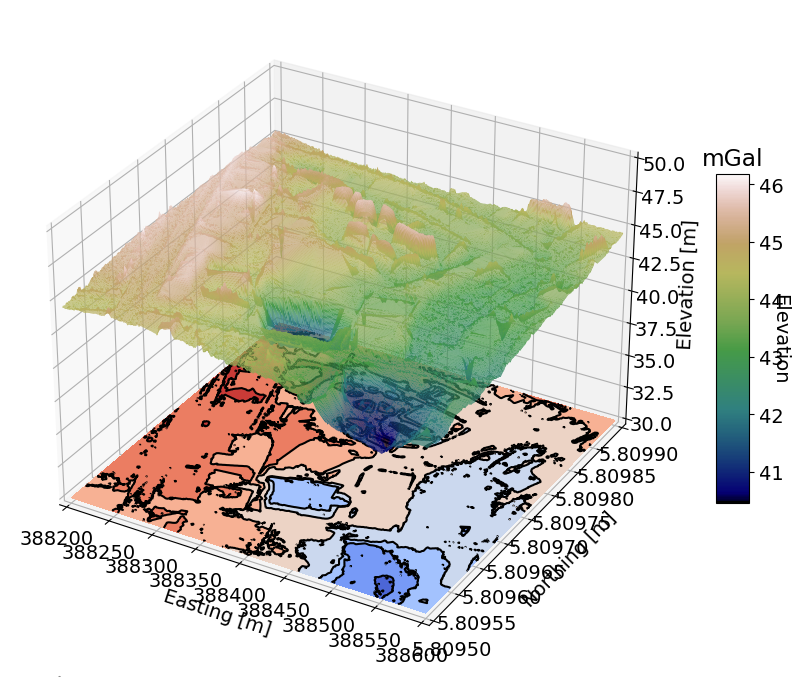

In [8]:
#-----------------------------------------------------------------------
# plot multiple figure
#-----------------------------------------------------------------------

axs = plt.figure(figsize=(10.0,7.0)).add_subplot(projection='3d')
# 3D axes
axs.set_xlim(easting.min(),easting.max())
axs.set_ylim(northing.min(),northing.max())
axs.set_zlim(30,50)
axs.set_xlabel('Easting [m]')
axs.set_ylabel('Northing [m]')
axs.set_zlabel('Elevation [m]')

surf=axs.plot_surface(xi,yi,zi, rstride=1, cstride=1, alpha=1.0, linewidth=0,cmap=cm.gist_earth)
#ax.contour(xi,yi,zi, cmap=cm.gist_earth)
axs.contourf(xi,yi,zi, zdir='z', offset=30, cmap=cm.coolwarm)
axs.contour(xi,yi,zi, colors='black', offset=30)
axs.ticklabel_format(useOffset=False)
cbar=fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_title('mGal')
cbar.set_label('Elevation',rotation=270)
plt.tight_layout()
plt.savefig("images/FUGeocampus_3Dtopo.png")

... done